/tmp/ipykernel_62598/3634828807.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_pth)


True

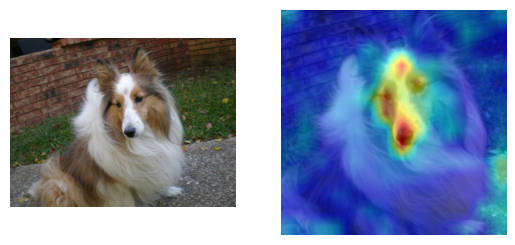

In [14]:
import cv2
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import models

# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    image_attn_blocks = list(dict(model.blocks.named_children()).values())

    # calculate index of last layer 
    start_layer = len(image_attn_blocks) - 1

    # one_hot.backward(retain_graph=True)
    attn_probs = attn_list[0]
    # print(attn_probs.shape)
    num_tokens = attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for i, blk in enumerate(image_attn_blocks):
        # if i < start_layer:
        #   continue
        attn_probs_i = attn_list[i]
        grad = torch.autograd.grad(one_hot, [attn_probs_i], retain_graph=True)[0].detach()
        cam = attn_probs_i.detach()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    return R[0, 1:]
def get_attn_probs(module, input, output):
    ## add attn_probs'calculate
    x = input[0]
    B, N, C = x.shape
    qkv = module.qkv(x).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

    attn = (q @ k.transpose(-2, -1)) * module.scale
    attn = attn.softmax(dim=-1)
    attn = module.attn_drop(attn)
    attn = attn.view(-1, N, N) ## sum batch_size dim
    # 保留 attn 张量的梯度
    attn.retain_grad()
    attn_list.append(attn)
    # print(module.num_heads)
    # print(attn.shape)
    
    attn = attn.reshape(B, -1, N, N)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = module.proj(x)
    x = module.proj_drop(x)
    return x

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize model pretrained
# model = getattr(models, 'SLIP_VITL16')(ssl_mlp_dim=4096, ssl_emb_dim=256, num_classes=1000)
model = getattr(models, 'SIMCLR_VITL16')(ssl_mlp_dim=4096, ssl_emb_dim=256, num_classes=1000)
# model = getattr(models, 'CLIP_VITL16')(num_classes=1000)
weights_pth = "/lpai/SLIP/checkpoint/simclr_large_25ep.pt"

weights = torch.load(weights_pth)
state_dict = weights['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    if not k.startswith("module."):
            continue
    old_k = k
    k = k.replace("module.", "")
    # print(old_k, "->", k)
    new_state_dict[k] = v
megss = model.load_state_dict(new_state_dict)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

model.to(device)
model.eval()

vision_model = model.visual
attn_list = []
for module in vision_model.blocks:
  module.attn.register_forward_hook(get_attn_probs)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = generate_relevance(vision_model, original_image.unsqueeze(0).cuda(), index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# def print_top_classes(predictions, **kwargs):    
#     # Print Top-5 predictions
#     prob = torch.softmax(predictions, dim=1)
#     class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
#     max_str_len = 0
#     class_names = []
#     for cls_idx in class_indices:
#         class_names.append(CLS2IDX[cls_idx])
#         if len(CLS2IDX[cls_idx]) > max_str_len:
#             max_str_len = len(CLS2IDX[cls_idx])
    
#     print('Top 5 classes:')
#     for cls_idx in class_indices:
#         output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
#         output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
#         output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
#         print(output_string)
# image = Image.open('/lpai/SLIP/exp_imgs/catdog.png')
image = Image.open('/lpai/dataset/imagenet-1k/0-1-0/val/ILSVRC2012_val_00000003.JPEG')
img = transform(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].axis('off')

# output = vision_model(img.unsqueeze(0).cuda())
img_show = generate_visualization(img)
axs[1].imshow(img_show)
axs[1].axis('off')
cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR, img_show)
cv2.imwrite('./cam_res/camall_simclr_large3.jpg', img_show)